In [33]:
from itertools import product
from collections import defaultdict
import operator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
sns.set()  # Applies seaborn style defaults to matplotlib

## Utility functions

In [34]:
def create_data(gate_operator):
    bits = [0, 1]
    num_input_bits = 2

    inputs = [list(pair) for pair in product(bits, repeat=num_input_bits)]
    outputs = [gate_operator(*pair) for pair in inputs]
    return inputs, outputs

def train(model, inputs, outputs, num_epochs, lr):
    losses = []

    loss_fxn = nn.BCELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    
    inputs = Variable(inputs, requires_grad=True)
    outputs = Variable(outputs)

    for _ in xrange(num_epochs):
        predictions = model(inputs)
        loss = loss_fxn(predictions, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data[0])
    return losses

def create_loss_plot(losses, title):
    plt.plot(losses);
    plt.xlabel('iters');
    plt.ylabel('loss');
    plt.title(title);
    
def create_decision_boundary_plot(model, inputs, outputs, title):
    # https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot
    # https://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels

    groups = defaultdict(list)
    for i in xrange(len(outputs)):
        groups[outputs[i]].append(inputs[i])
        
    colors = ['blue', 'green']
    for output, input in groups.iteritems():
        plt.scatter(*zip(*input), c=colors[output], label=output);
        
    plt.xlabel('input 1');
    plt.ylabel('input 2');
    plt.title(title);
    plt.legend(loc=1)

    bits = [0, 1]
    step = 0.01
    x_min, x_max = min(bits) - 1, max(bits) + 1
    y_min, y_max = x_min, x_max

    xx, yy = np.meshgrid(
                np.arange(x_min, x_max, step),
                np.arange(y_min, y_max, step)
            )

    mesh_inputs = np.c_[xx.ravel(), yy.ravel()]
    predictions = model(Variable(torch.Tensor(mesh_inputs), requires_grad=False))
    predictions = predictions.data.numpy().reshape(xx.shape)

    plt.contour(xx, yy, np.around(predictions), colors=['red']);
    plt.plot();

## `AND` with single neuron.

In [35]:
inputs, outputs = create_data(operator.and_)

# Build model.
num_input_bits = 2
num_output_bits = 1
model = nn.Sequential(
            nn.Linear(num_input_bits, num_output_bits),
            nn.Sigmoid()
        )

input_tensor = torch.Tensor(inputs)
output_tensor = torch.Tensor(outputs).unsqueeze(-1)
losses = train(model, input_tensor, output_tensor, num_epochs=2000, lr=0.1)

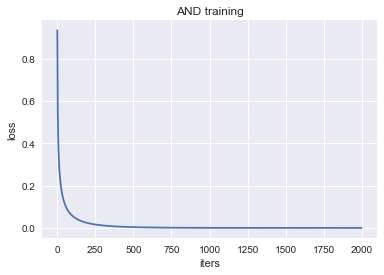

In [37]:
create_loss_plot(losses, title='AND training')

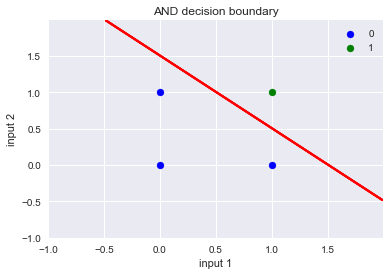

In [38]:
create_decision_boundary_plot(model, inputs, outputs, title='AND decision boundary')

As expected, the perceptron successfully finds a decision boundary which splits the labels. Now let's see what happens for an `XOR` gate.

## `XOR` with single neuron.

In [39]:
inputs, outputs = create_data(operator.xor)

# Build model.
model = nn.Sequential(
            nn.Linear(num_input_bits, num_output_bits),
            nn.Sigmoid()
        )

input_tensor = torch.Tensor(inputs)
output_tensor = torch.Tensor(outputs).unsqueeze(-1)
losses = train(model, input_tensor, output_tensor, num_epochs=1000, lr=0.01)

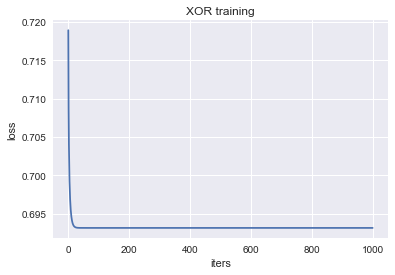

In [41]:
create_loss_plot(losses, title='XOR training')

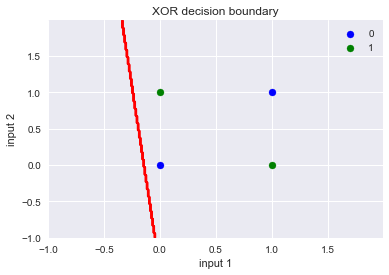

In [42]:
create_decision_boundary_plot(model, inputs, outputs, title='XOR decision boundary')

The perceptron is unable to approximate the `XOR` gate! This is due to the fact that the `XOR` problem is not 
[linearly seperable][1] i.e. there is no **single** line which can seperate the two classes. To address this problem, we simply need to add an additional perceptron which, in turn, introduces an **additional decision boundary**.

[1]: https://en.wikipedia.org/wiki/Linear_separability

## `XOR` with 2 neurons.

In [52]:
inputs, outputs = create_data(operator.xor)

# Build model.
num_hidden_units = 2
model = nn.Sequential(
            nn.Linear(num_input_bits, num_hidden_units),
            nn.Sigmoid(),
            nn.Linear(num_hidden_units, num_output_bits),
            nn.Sigmoid()
        )

input_tensor = torch.Tensor(inputs)
output_tensor = torch.Tensor(outputs).unsqueeze(-1)
losses = train(model, input_tensor, output_tensor, num_epochs=5000, lr=0.01)

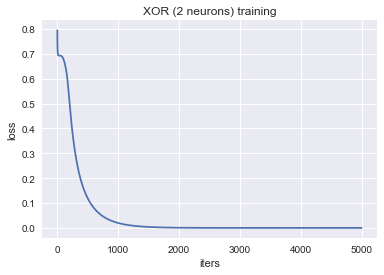

In [53]:
create_loss_plot(losses, title='XOR (2 neurons) training')

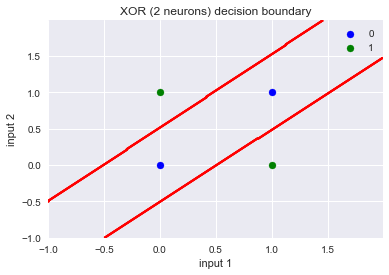

In [54]:
create_decision_boundary_plot(model, inputs, outputs, title='XOR (2 neurons) decision boundary')

For more information, as well as visualizations, see:
  * [Quora: What is XOR problem in neural networks?][1]
  * [XOR problem theory][2]


[1]: https://www.quora.com/What-is-XOR-problem-in-neural-networks
[2]: http://home.agh.edu.pl/~vlsi/AI/xor_t/en/main.htm